# Import

In [1]:
import numpy as np
from keras.models import Model
from keras.layers import Dense,Bidirectional,Activation, Input, Lambda,LSTM,Dropout,ConvLSTM2D,Conv2D,Conv1D,MaxPooling2D,MaxPooling1D, GlobalMaxPooling1D,Reshape, Flatten,TimeDistributed
from sklearn.model_selection import train_test_split
import keras.optimizers as ko
from keras.utils import plot_model
from keras.models import load_model
from keras import backend as K
import tensorflow as tf
import librosa as lb
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import freqz
import os
import glob
import copy
import seaborn as sns
import re
import pickle
import operator
import IPython.display as ipd
import itertools
import numpy.random as rng
import random

Using TensorFlow backend.


In [2]:
tf.executing_eagerly()

True

# Utility functions

In [3]:
def filter_by_freq(target,threshold):
    filtered = dict()
    for key in target:
        if len(target[key]) >= threshold:
            filtered[key] = target[key]
    return filtered

#Load support set from selection
def create_support_set(sel_keys,selection,total,filtered,full):
    support_set = dict()
    for i in range(0, len(sel_keys)):
        support_set[sel_keys[i]] = filtered[sel_keys[i]][selection[i]]

    #If true adds rare phrases (those with less than 12 instances)
    if full:
        #load support set for rare phrases (with less than 12 tokens)
        rare_phrases = { k : total[k] for k in set(total) - set(filtered) }
        for key in rare_phrases.keys():
            support_set[key]= librosa.load(rare_phrases[key][0]) #Choose the first one
    return support_set 

def remv_support_set(sel_keys,selection,filtered):
    #Remove support set instances from filtered set. 
    new_filtered = copy.deepcopy(filtered)
    for i in range(len(sel_keys)):
        a = new_filtered[sel_keys[i]]
        del a[selection[i]]
        new_filtered[sel_keys[i]] = a
    return new_filtered

def split_set(new_filtered,train_size):
    #Returns train and test set
    train = dict()
    test = dict()
    for k in new_filtered.keys():
        #train[k],test[k] = train_test_split(new_filtered[k],train_size=train_size, random_state=rand_state)
        train[k],test[k] = train_test_split(new_filtered[k],train_size=train_size)
    return train, test

In [4]:
#Generate train set for k-shot learning
def get_batch(dataset,k,n):
    """Create batch of 2*n pairs per class using up to k examples, n same class, n different class"""
    pairs = []
    labels = []
    categories = dataset.keys()

  #Create subset of dataset with only k elements per class
    k_set = dict()
    for cat in categories:
        k_set[cat] = random.sample(dataset[cat],k) #Take k samples with no replacement per class

    for i in range(n):
        for cat in categories:
            z1, z2 = random.choice(k_set[cat]), random.choice(k_set[cat])
            pairs += [[z1,z2]] #Same class pair     
          #Pick a a different category than current "cat"
            while True:   
                notcat = random.choice(list(categories))
                if(notcat != cat):  
                    break  
            z1, z2 = random.choice(k_set[cat]), random.choice(k_set[notcat])
            pairs += [[z1,z2]] #different class pair
            labels += [1, 0] #1 to same pairs, 0 to contrastive
    return np.array(pairs), np.array(labels)

# Load features from all phrases

In [5]:
with open("features_total.pkl", "rb") as input_file:
    total_features = pickle.load(input_file)

In [6]:
#Transpose vectors and compute decibels
for k in total_features.keys():
    for i in range(len(total_features[k])):
        total_features[k][i] = lb.amplitude_to_db(total_features[k][i],top_db=65.0)
        total_features[k][i] = total_features[k][i].astype('int8')
        #total_features[k][i] = np.transpose(total_features[k][i])

In [7]:
#Get most common phrases
filt_features = filter_by_freq(total_features,12)
total_features = 0

# Support set

In [8]:
#Create support set from averages
support_set = dict()
for k in filt_features.keys():
    support_set[k] = np.mean(filt_features[k],axis=0)

In [ ]:
#Create support set from selection
#Support set keys and indices. Remember to exclude them when loading test and train sets
sel_keys = ['aa', 'ab', 'ac', 'ad', 'ae', 'af', 'ag','ah', 'ai', 'aj','ak','am','an','ao','ap',
            'aq','ar','as','au','ba','bc','bd','be',
            'bf','bi','bj','bl','bm','bp','br','bu','bx']
selection = [0,3,6,0,7,5,6,6,1,11,6,5,2,5,6,7,11,7,9,5,4,7,4,6,4,5,5,5,0,1,3,1]
support_set = create_support_set(sel_keys,selection,total_features,filt_features,full=False)

In [28]:
#Get filtered set without support set common phrase instances
filt_features = remv_support_set(sel_keys,selection,filt_features)

NameError: name 'sel_keys' is not defined

In [9]:
#Get traning and test set (mfccs)
train_set, test_set = split_set(filt_features,7)

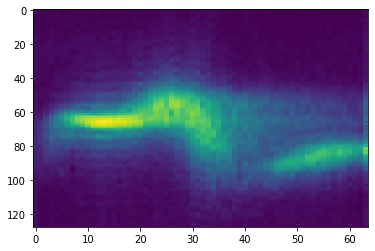

In [10]:
#plt.imshow(np.transpose(filt_features['bj'][0]),aspect='auto')
plt.imshow(np.transpose(support_set['aa']),aspect='auto')

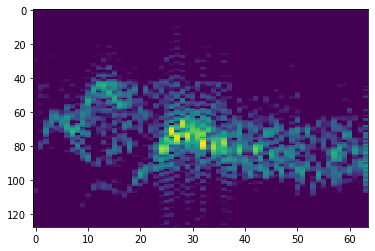

In [11]:
plt.imshow(np.transpose(train_set['aj'][0]),aspect='auto')

# Generate pairs

In [12]:
train_pairs, train_labels =  get_batch(train_set,7,1000)
num_train_pairs = len(train_pairs)

#To know the maximum number that can be sampled for all classes
min_phrases_test = min([len(i) for i in test_set.values()])

test_pairs, test_labels = get_batch(test_set,min_phrases_test,100)
num_test_pairs = len(test_pairs)

In [13]:
te1 = test_pairs[:,0,:,:]
te2 = test_pairs[:,1,:,:]
tr1 = train_pairs[:,0,:,:]
tr2 = train_pairs[:,1,:,:]
support_set_array = np.array([s for s in list(support_set.values())])

In [14]:
test_pairs = 0
train_pairs = 0

# Define Keras model

In [15]:
def testModel(input_shape):
    input_seq = Input(shape=input_shape)
    x = Reshape((64,128,1))(input_seq)
    x = Conv2D(8, (3,3), activation='relu')(x)
    x = Conv2D(8, (3,3), activation='relu')(x)
    x = Conv2D(8, (3,3), activation='relu')(x)
    x = Conv2D(8, (3,3), activation='relu',padding="same")(x)
    x = Conv2D(8, (3,3), activation='relu')(x)
    x = Conv2D(16, (3,3), activation='relu')(x)
    x = Conv2D(16, (4,4), activation='relu')(x)
    x = Conv2D(16, (4,4), activation='relu')(x)
    x = Conv2D(16, (4,4), activation='relu',padding="same")(x)
    x = MaxPooling2D(2)(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(512,return_sequences=True)(x)
    x = LSTM(128,return_sequences=True)(x)
    x = LSTM(128)(x)
    x = Dense(128,activation='relu')(x)
    x = Dense(128,activation='relu')(x)
    x = Dense(128)(x)
    x = Dropout(0.1)(x)
    encoded = Activation("relu")(x)
    return Model(input_seq,encoded,name="LSTM")

In [16]:
def LSTM_branch2(input_shape):
    input_seq = Input(shape=input_shape)
    x = Bidirectional(LSTM(128,return_sequences=True),merge_mode='ave')(input_seq)
    x = Bidirectional(LSTM(128,return_sequences=True),merge_mode='ave')(x)
    x = Bidirectional(LSTM(128))(x)
    x = Dense(128,activation='relu')(x)
    x = Dense(128,activation='relu')(x)
    x = Dense(128)(x)
    x = Dropout(0.1)(x)
    encoded = Activation("relu")(x)
    return Model(input_seq,encoded,name="LSTM")

In [17]:
def LSTM_branch(input_shape):
    input_seq = Input(shape=input_shape)
    x = LSTM(128,return_sequences=True)(input_seq)
    x = LSTM(128,return_sequences=True)(x)
    x = LSTM(128)(x)
    x = Dense(128,activation='relu')(x)
    x = Dense(128,activation='relu')(x)
    x = Dense(128)(x)
    x = Dropout(0.1)(x)
    encoded = Activation("relu")(x)
    return Model(input_seq,encoded,name="LSTM")

In [18]:
# Loss and metrics
def euclidean_distance(vects):
    x, y = vects
    #return K.sqrt(K.sum(K.square(x - y), axis=-1, keepdims=True))
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [19]:
input_shape = (64,128) #(Timesteps,n_features)
lstm = LSTM_branch2(input_shape)
inputA = Input(shape=input_shape,name="InputA")
inputB = Input(shape=input_shape,name="InputB")
encodedA = lstm(inputA)
encodedB = lstm(inputB)

In [20]:
lstm.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64, 128)           263168    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64, 128)           263168    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512  

In [21]:
distance = Lambda(euclidean_distance,output_shape=eucl_dist_output_shape,name="distance")([encodedA, encodedB])

In [22]:
siameseLSTM = Model([inputA,inputB],distance)

In [23]:
siameseLSTM.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputA (InputLayer)             (None, 64, 128)      0                                            
__________________________________________________________________________________________________
InputB (InputLayer)             (None, 64, 128)      0                                            
__________________________________________________________________________________________________
LSTM (Model)                    (None, 128)          855424      InputA[0][0]                     
                                                                 InputB[0][0]                     
__________________________________________________________________________________________________
distance (Lambda)               (None, 1)            0           LSTM[1][0]                 

In [24]:
siameseLSTM.compile(optimizer='adam', loss=contrastive_loss)

In [25]:
#history = siameseLSTM.fit([tr1,tr2], train_labels,epochs=5,batch_size=256,shuffle=True)
siameseLSTM.fit([tr1,tr2], train_labels,epochs=5,batch_size=256,shuffle=True)

Epoch 1/5
64000/64000 [==============================] - 110s 2ms/step - loss: 0.0979
Epoch 2/5
64000/64000 [==============================] - 103s 2ms/step - loss: 0.0616
Epoch 3/5
64000/64000 [==============================] - 104s 2ms/step - loss: 0.0572
Epoch 4/5
64000/64000 [==============================] - 103s 2ms/step - loss: 0.0554
Epoch 5/5
64000/64000 [==============================] - 104s 2ms/step - loss: 0.0541


In [26]:
v_pred = siameseLSTM.predict([te1,te2])

In [27]:
compute_accuracy(test_labels,v_pred)

0.95671875

In [28]:
import pandas as pd

In [29]:
#Create classification set
def create_classif_task(test_set):
    classif_test = []
    classif_labels = []

    #use the full test set
    for k in test_set.keys():
        for a in test_set[k]:
            classif_test.append(a)
            classif_labels.append(k)
    return (np.array(classif_test),classif_labels)

def get_predictions(support_set,classif_test):
    predictions = []
    support_set_array = np.array([s for s in list(support_set.values())])
    classif_test_repeated = np.repeat(classif_test,len(support_set_array),axis=0)
    I, L = pd.factorize(list(support_set.keys()))
    for k in range(len(classif_test)):
        pred_support = siameseLSTM.predict([classif_test_repeated[32*k:32+32*k],support_set_array]).ravel()
        pred_class = np.where(pred_support == np.min(pred_support))[0][0]
        predictions.append(L[pred_class])
    return predictions

In [30]:
classif_test, classif_labels = create_classif_task(test_set)

In [82]:
#Total syllables
sum([len(filt_features[k]) for k in filt_features.keys()])

AttributeError: 'int' object has no attribute 'keys'

In [31]:
#Test syllables
len(classif_test)

809

In [32]:
predictions = get_predictions(support_set,classif_test)

In [33]:
boolean = [predictions[i] == classif_labels[i] for i in range(len(predictions))]
np.mean(boolean)

0.8825710754017305

In [34]:
#accuracy per class
accuracy = dict()
for k in test_set.keys():
    k_indices = list(filter(lambda x: classif_labels[x] == k, range(len(classif_labels))))
    accuracy[k] = np.mean([predictions[i] == classif_labels[i] for i in k_indices])

In [35]:
accuracy

{'aa': 0.7083333333333334,
 'ab': 1.0,
 'ac': 0.9545454545454546,
 'ad': 0.9,
 'ae': 1.0,
 'af': 0.7837837837837838,
 'ag': 1.0,
 'ah': 0.8421052631578947,
 'ai': 1.0,
 'aj': 0.9696969696969697,
 'ak': 0.967741935483871,
 'am': 0.918918918918919,
 'an': 0.9090909090909091,
 'ao': 0.9444444444444444,
 'ap': 1.0,
 'aq': 0.8285714285714286,
 'ar': 0.6060606060606061,
 'as': 0.723404255319149,
 'au': 0.8775510204081632,
 'ba': 0.9444444444444444,
 'bc': 0.9615384615384616,
 'bd': 1.0,
 'be': 1.0,
 'bf': 1.0,
 'bi': 1.0,
 'bj': 1.0,
 'bl': 1.0,
 'bm': 0.7941176470588235,
 'bp': 0.88,
 'br': 0.8333333333333334,
 'bu': 0.6875,
 'bx': 0.8125}